In [85]:
# !pip install pybaseball
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install pickle5
# !pip install datetime2
!pip install yellowbrick


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 3.3 MB/s eta 0:00:0000:0100:01


In [89]:
# Start by importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

from pybaseball import schedule_and_record
from pybaseball import statcast
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import team_batting
from pybaseball import team_pitching
from pybaseball import batting_stats
from pybaseball import pitching_stats
from pybaseball import batting_stats_range
from pybaseball import pitching_stats_range
from pybaseball import statcast_single_game
from pybaseball import playerid_reverse_lookup

# Data Importing

### Playerid references

In [22]:
x=list(range(100000,800000))
all_players=playerid_reverse_lookup(x)
all_players=pd.DataFrame(all_players)
all_players=all_players[all_players.key_fangraphs!=-1]

Gathering player lookup table. This may take a moment.


In [23]:
all_players.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,aardsma,david,430911,aardd001,aardsda01,1902,2004.0,2015.0
1,aaron,hank,110001,aaroh101,aaronha01,1000001,1954.0,1976.0
2,aaron,tommie,110002,aarot101,aaronto01,1000002,1962.0,1971.0
3,aase,don,110003,aased001,aasedo01,1000003,1977.0,1990.0
4,abad,andy,407577,abada001,abadan01,506,2001.0,2006.0


In [95]:
all_players.dtypes

name_last            object
name_first           object
key_mlbam             int64
key_retro            object
key_bbref            object
key_fangraphs         int64
mlb_played_first    float64
mlb_played_last     float64
dtype: object

### statcast pitch level data

We can start by pulling all pitch level data from the past 2 years

In [78]:
begining_date = '2021-04-01'
ending_date = '2022-08-02'

In [26]:
all_play_data=statcast(begining_date,ending_date)

This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 370/370 [04:33<00:00,  1.35it/s]


In [52]:
all_play_data['ticker'] = 1

In [101]:
all_play_data.dtypes

pitch_type                       object
game_date                datetime64[ns]
release_speed                   Float64
release_pos_x                   Float64
release_pos_z                   Float64
                              ...      
of_fielding_alignment            object
spin_axis                         Int64
delta_home_win_exp              Float64
delta_run_exp                   Float64
ticker                            int64
Length: 93, dtype: object

In [106]:
def get_all_starters(data,lookback_start,lookback_end):
    missing_pitchers = []
    dates=pd.date_range(lookback_start,lookback_end)
    all_starters={}
    for day in dates:
        day_starters=[]
        day_data=data[data.game_date==day]
        today_games=day_data.game_pk.unique()
        for game in today_games:
            game_stats=day_data[day_data.game_pk==game]
            home_counter=0
            away_counter=0
            l=game_stats.pitcher.value_counts().keys()
            for pitcher in l:
                m=game_stats[game_stats.pitcher==pitcher]
                m.reset_index(drop=True, inplace=True)
                if home_counter==0 and m.inning_topbot[0]=='Bot':
                    home_starter_id=pitcher
                    home_counter+=1
                elif away_counter==0 and m.inning_topbot[0]=='Top':
                    away_starter_id=pitcher
                    away_counter=+1
                else: 
                    None
            try:
                home_holder=all_players[all_players.key_mlbam==home_starter_id]
                home_holder.reset_index(drop=True,inplace=True)
                home_starter_name=str(home_holder.name_first[0])+' '+str(home_holder.name_last[0])
                away_holder=all_players[all_players.key_mlbam==away_starter_id]
                away_holder.reset_index(drop=True,inplace=True)
                away_starter_name=str(away_holder.name_first[0])+' '+str(away_holder.name_last[0])
                day_starters.append(home_starter_name)
                day_starters.append(away_starter_name)
            except:
                missing_pitchers.append(home_starter_id)
        exit_date=day.strftime('%Y-%m-%d')
        all_starters.update({exit_date:day_starters})
    return all_starters, missing_pitchers
starters_on_day, missing_pitchers=get_all_starters(all_play_data,begining_date,ending_date)

In [110]:
all_play_data[['pitcher', 'player_name']].head()

,pitcher,player_name
3577,650671,"Quijada, José"
3713,650671,"Quijada, José"
3769,650671,"Quijada, José"
3929,650671,"Quijada, José"
4144,650671,"Quijada, José"


In [108]:
len(missing_pitchers)
#missing_pitchers.merge(all)

44

In [103]:
starters_on_day

{'2021-04-01': ['lucas giolito',
  'dylan bundy',
  'tyler glasnow',
  'sandy alcantara',
  'shane bieber',
  'matt boyd',
  'hyun jin ryu',
  'gerrit cole',
  'zack greinke',
  'chris bassitt',
  'kenta maeda',
  'brandon woodruff',
  'jack flaherty',
  'luis castillo',
  'chad kuhl',
  'kyle hendricks',
  'taylor hearn',
  'brad keller',
  'kevin gausman',
  'marco gonzales',
  'max fried',
  'aaron nola',
  'madison bumgarner',
  'yu darvish',
  'clayton kershaw',
  'germán márquez'],
 '2021-04-02': ['trevor bauer',
  'antonio senzatela',
  'dallas keuchel',
  'andrew heaney',
  'john means',
  'nathan eovaldi',
  'cristian javier',
  'jesús luzardo',
  'ryan yarbrough',
  'pablo lópez',
  'johnny cueto',
  'yusei kikuchi',
  'merrill kelly',
  'blake snell'],
 '2021-04-03': ['adam wainwright',
  'tyler mahle',
  'lance lynn',
  'alex cobb',
  'ross stripling',
  'corey kluber',
  'tyler anderson',
  'jake arrieta',
  'logan webb',
  'chris flexen',
  'walker buehler',
  'jon gray',

In [39]:
all_play_data.groupby(['game_year'], as_index=False).agg({'game_pk':'nunique'})

,game_year,game_pk
0,2021,2466
1,2022,1825


In [40]:
all_play_data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [51]:
all_play_data['pitcher.1'].nunique()

1558

In [82]:
pitch_count_df = all_play_data.groupby(['pitcher.1', 'pitch_type'], as_index=False).agg({'ticker':'sum'}).pivot(index='pitcher.1',columns='pitch_type', values='ticker')
pitch_count_df.fillna(0, inplace=True)
pitch_perc_df=pitch_count_df.div(pitch_count_df.sum(axis=1), axis=0)

In [83]:
pitch_perc_df.head()

pitch_type,CH,CS,CU,EP,FA,FC,FF,FS,FT,KC,KN,SC,SI,SL
pitcher.1,,,,,,,,,,,,,,
405395,0.000000,0.000000,0.296296,0.000000,0.703704,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
424144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.0,0.0,0.0,0.0,0.0,0.562500,0.31250
425794,0.067854,0.008247,0.311715,0.000000,0.000000,0.229241,0.098969,0.0,0.0,0.0,0.0,0.0,0.283974,0.00000
425844,0.202703,0.001422,0.168800,0.000474,0.002134,0.045282,0.387387,0.0,0.0,0.0,0.0,0.0,0.048127,0.14367
425877,0.000000,0.000000,0.500000,0.025000,0.300000,0.000000,0.150000,0.0,0.0,0.0,0.0,0.0,0.000000,0.02500


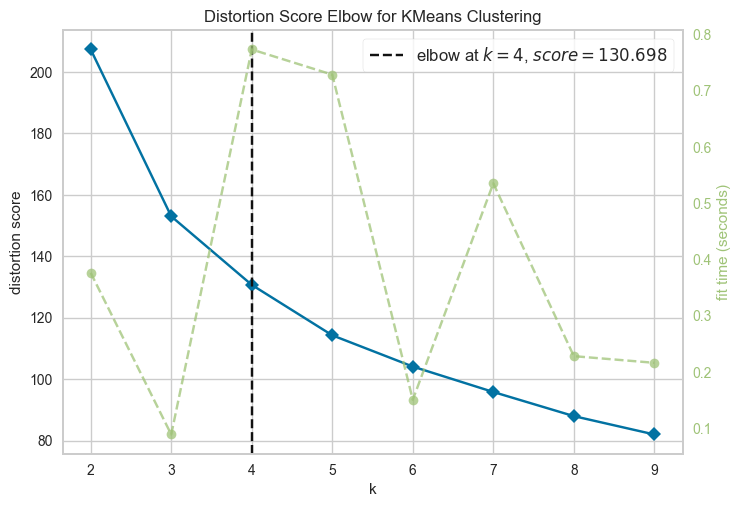

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(pitch_perc_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

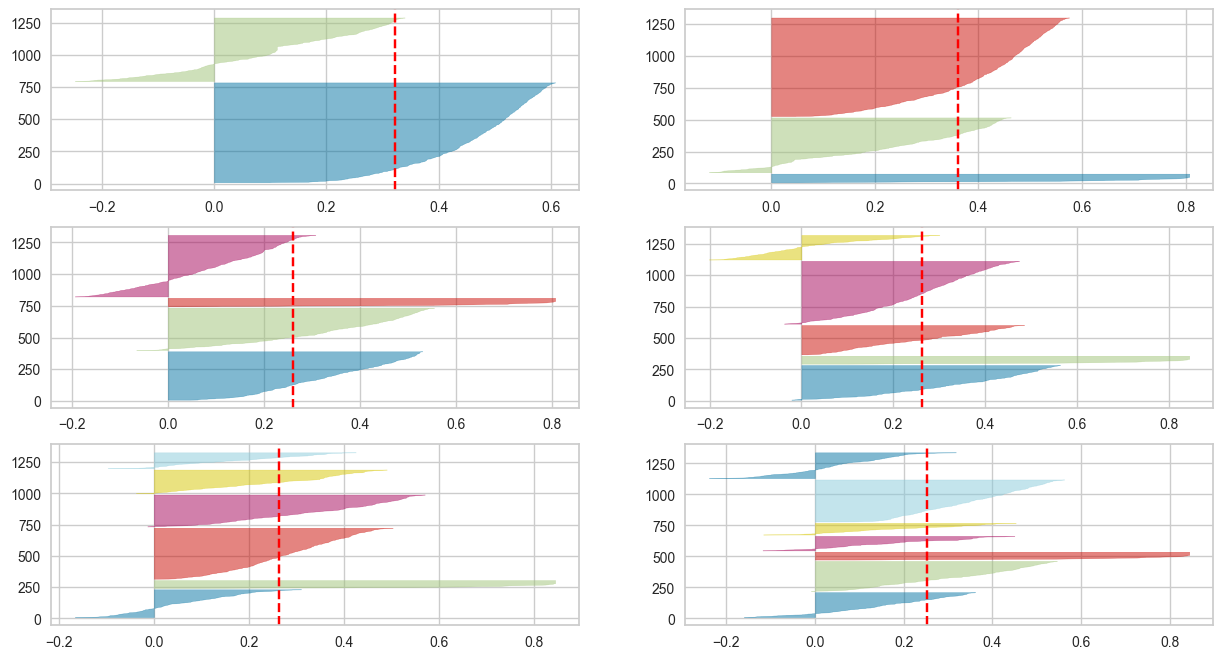

In [93]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(pitch_perc_df) 

In [60]:
all_play_data.groupby(['game_pk', 'pitcher.1', 'pitch_type'],
                         as_index=False).agg({'ticker':'sum'}).pivot(index=['game_pk', 'pitcher.1'],columns='pitch_type', values='ticker')

pitch_type          CH  CS    CU  EP  FA    FC    FF  FS  FT  KC  KN  SC  \
game_pk pitcher.1                                                          
632169  459429     NaN NaN   NaN NaN NaN   NaN  16.0 NaN NaN NaN NaN NaN   
        468504     NaN NaN   6.0 NaN NaN   NaN   4.0 NaN NaN NaN NaN NaN   
        571710     1.0 NaN   NaN NaN NaN   NaN   4.0 NaN NaN NaN NaN NaN   
        592346     7.0 NaN   NaN NaN NaN  11.0  45.0 NaN NaN NaN NaN NaN   
        606625     3.0 NaN   NaN NaN NaN   NaN   8.0 NaN NaN NaN NaN NaN   
...                ...  ..   ...  ..  ..   ...   ...  ..  ..  ..  ..  ..   
707117  663385     NaN NaN   NaN NaN NaN   NaN   NaN NaN NaN NaN NaN NaN   
        664092     NaN NaN   NaN NaN NaN   NaN   NaN NaN NaN NaN NaN NaN   
        669020     5.0 NaN  13.0 NaN NaN   NaN  23.0 NaN NaN NaN NaN NaN   
        674072     8.0 NaN   1.0 NaN NaN   NaN  22.0 NaN NaN NaN NaN NaN   
        686933     NaN NaN   NaN NaN NaN   NaN   NaN NaN NaN NaN NaN NaN   

pitch_type           SI    SL  
game_pk pitcher.1              
632169  459429      NaN   NaN  
        468504      6.0   NaN  
        571710      NaN   2.0  
        592346      3.0  14.0  
        606625      NaN   3.0  
...                 ...   ...  
707117  663385      1.0   NaN  
        664092     11.0   7.0  
        669020      NaN   3.0  
        674072      NaN   7.0  
        686933      NaN   4.0  

[36581 rows x 14 columns]

In [16]:
# fangraphs data pull
pitching_df = pitching_stats(2021, 2022)
batting_df = batting_stats(2021, 2022)

In [19]:
print(batting_df.shape)
print(pitching_df.shape)

(262, 320)
(84, 334)


In [20]:
pitching_df

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,LA,Barrels,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xERA
6,19361,2021,Corbin Burnes,MIL,26,11,5,7.5,2.43,28,...,8.4,12,0.031,114.2,117,0.305,383,0.172,0.338,NaN
14,10310,2021,Zack Wheeler,PHI,31,14,10,7.2,2.78,32,...,8.4,25,0.046,118.6,156,0.285,548,0.156,0.280,NaN
38,16149,2022,Aaron Nola,PHI,29,11,13,6.3,3.25,32,...,12.5,38,0.071,112.0,169,0.316,534,0.197,0.324,NaN
19,16137,2022,Carlos Rodon,SFG,29,14,8,6.2,2.88,31,...,19.4,27,0.065,112.5,166,0.397,418,0.164,0.306,NaN
0,8700,2022,Justin Verlander,HOU,39,18,4,6.1,1.75,28,...,16.9,28,0.063,110.9,155,0.348,446,0.150,0.265,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,14168,2022,Jose Berrios,TOR,28,12,7,1.1,5.23,32,...,13.9,52,0.095,113.8,238,0.434,548,0.184,0.277,NaN
82,9434,2021,Dallas Keuchel,CHW,33,9,9,0.7,5.28,32,...,5.0,50,0.089,115.6,222,0.397,559,0.167,0.255,NaN
83,9323,2021,Patrick Corbin,WSN,31,9,16,0.2,5.82,31,...,9.0,50,0.092,112.9,222,0.407,545,0.153,0.265,NaN
64,15467,2022,Marco Gonzales,SEA,30,10,15,0.1,4.13,32,...,14.5,45,0.072,111.2,215,0.345,623,0.151,0.235,NaN


In [18]:
batting_df.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
0,15640,2022,Aaron Judge,NYY,30,157,570,696,177,87,...,118.4,246,0.609,404,0.169,0.287,NaN,NaN,NaN,11.2
18,11493,2022,Manny Machado,SDP,29,150,578,644,172,102,...,112.4,219,0.490,447,0.126,0.243,NaN,NaN,NaN,6.6
6,19709,2021,Fernando Tatis Jr.,SDP,22,130,478,546,135,62,...,116.6,183,0.556,329,0.102,0.270,NaN,NaN,NaN,6.2
19,9777,2022,Nolan Arenado,STL,31,148,557,620,163,90,...,111.4,190,0.389,489,0.155,0.241,NaN,NaN,NaN,7.2
4,9218,2022,Paul Goldschmidt,STL,34,151,561,651,178,102,...,112.3,200,0.469,426,0.196,0.295,NaN,NaN,NaN,8.0


In [20]:
data2 = schedule_and_record(2022, 'MIL')

In [25]:
data2

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled
1,"Thursday, Apr 7",MIL,@,CHC,L,4.0,5.0,9.0,0-1,4.0,1.0,Givens,Ashby,Robertson,3:18,D,35112.0,.99,-1.0,None
2,"Saturday, Apr 9",MIL,@,CHC,L,0.0,9.0,9.0,0-2,4.0,2.0,Steele,Woodruff,None,3:28,D,30369.0,.99,-2.0,None
3,"Sunday, Apr 10",MIL,@,CHC,W,5.0,4.0,9.0,1-2,4.0,1.0,Cousins,Norris,Hader,3:03,D,32858.0,.93,1.0,None
4,"Monday, Apr 11",MIL,@,BAL,L,0.0,2.0,9.0,1-3,5.0,1.5,Baumann,Houser,Lopez,3:24,D,44461.0,.89,-1.0,None
5,"Tuesday, Apr 12",MIL,@,BAL,W,5.0,4.0,9.0,2-3,3.0,1.5,Milner,Bautista,Hader,3:38,N,11814.0,.87,1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,"Saturday, Oct 1",MIL,Home,MIA,None,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,None
159,"Sunday, Oct 2",MIL,Home,MIA,None,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,None
160,"Monday, Oct 3",MIL,Home,ARI,None,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,None
161,"Tuesday, Oct 4",MIL,Home,ARI,None,NaN,NaN,NaN,None,NaN,None,None,None,None,None,None,NaN,None,NaN,None


In [29]:
data3.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
3,19709,2021,Fernando Tatis Jr.,SDP,22,130,478,546,135,62,...,0.213,116.6,183,0.556,329,0.102,0.270,0.279,0.618,0.406
1,20123,2021,Juan Soto,WSN,22,151,502,654,157,106,...,0.133,116.6,217,0.524,414,0.200,0.263,0.304,0.544,0.430
8,16252,2021,Trea Turner,- - -,28,148,595,646,195,130,...,0.074,112.2,225,0.460,489,0.160,0.262,0.303,0.484,0.362
9,19326,2021,Bryan Reynolds,PIT,26,159,559,646,169,102,...,0.104,112.7,181,0.408,444,0.123,0.231,0.293,0.522,0.385
0,11579,2021,Bryce Harper,PHI,28,141,488,599,151,73,...,0.181,116.3,177,0.492,360,0.119,0.263,0.301,0.610,0.430
